#### TMA4205 Numerical Linear Algebra
# Project Part 1
## Introduction

In this project we solve the 2D Poisson equation

\begin{aligned}
\Delta u  &= f \quad \text{on} \quad D = [0,1]^2 \\
u &= g  \quad \text{on} \quad \partial D
\end{aligned}

numerically. The equation is discretized  as a finite difference scheme using the five point stencil.
For each dimension we use $N+1$ nodes distance $h:=1/N$ from each other.

The discretization of the Poisson equation results in a system of linear equations.
We then solve the linear system by three different methods: conjugate gradient, multigrid and multigrid preconditioned conjugate gradient.
Specifically, a method working directly on the gridnodes will be used.
Thus, we need not store the discrete Laplacian operator.

In this project $\frac{||r_k||_2}{||r_0||_2} < 10^{-12}$ will be used as a convergence criterion for outer iterations for all algorithms. Here $r_k$ is the residual of the linear system after $k$ iterations of the algorithm.
Thus, in convergence plots the quantity $\frac{||r_k||_2}{||r_0||_2}$ is shown.


In [1]:
% load_ext autoreload
% autoreload 2

# imports and useful functions
import matplotlib.pyplot as plt

# line cyclers adapted to colourblind people
from cycler import cycler

line_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
               cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
plt.rc("axes", prop_cycle=line_cycler)
plt.rc('axes', axisbelow=True)

In [2]:
"""First define some useful functions for plotting and testing"""
from linalg.convergence import *

## Exercise 1:
In this part we implement and test the conjugate gradient algorithm.
In the cell below a version of the conjugate gradiant algorithm working directly on the grid is implemnted.

In [3]:
from linalg.iterative import cg

In the cell below the test problem for exercise 1 is implemented.
Here we also define the discrete laplacian which will be used in the rest of the exercises.

In [4]:
from test.case_one import CaseOne
from linalg.laplacian import neg_discrete_laplacian

We now use the test case to test the implementation of conjugate gradient.
The tests are done with three different grid sizes where $N \in [32, 64, 128]$.
The solution and a plot of the convergence history of $\frac{||r_k||_2}{||r_0||_2}$ is shown below,
where $r_k$ is the residual after $k$ iterations.
The convergence criterion $\frac{||r_k||_2}{||r_0||_2} < 10^{-12}$ will be used in the rest of the algorithms as well.

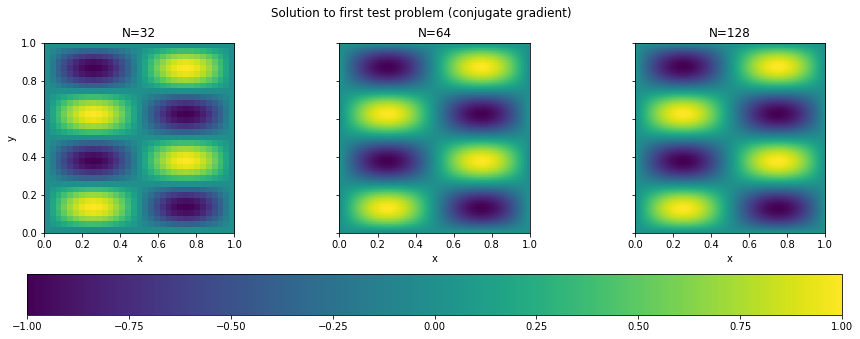

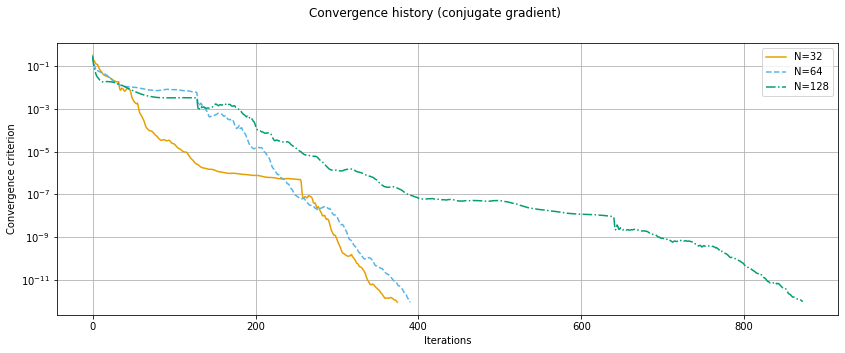

In [5]:
N_list = [32, 64, 128]
fig, axs = plt.subplots(ncols=len(N_list), sharey=True, figsize=(15, 5))
fig.suptitle("Solution to first test problem (conjugate gradient)")

fig_conv, axs_conv = plt.subplots(1, figsize=(14, 5))
axs_conv.set_ylabel("Convergence criterion")
axs_conv.set_xlabel("Iterations")
fig_conv.suptitle("Convergence history (conjugate gradient)")
axs_conv.grid()
for i, N in enumerate(N_list):
    rhs = CaseOne.get_rhs(N)
    U_0 = CaseOne.get_u_0(N)
    U_num, conv_hist = cg(A=neg_discrete_laplacian, x_0=U_0, rhs=rhs, N=N, tol=1e-12, maxiter=3000, conv_hist=True)
    im = axs[i].imshow(U_num.T, origin="lower", extent=[0, 1, 0, 1], label=f"N={N}", interpolation=None)

    axs[0].set_ylabel("y")
    axs[i].set_xlabel("x")
    axs[i].set_title(f"N={N}")
    axs_conv.semilogy(conv_hist, label=f"N={N}")

fig.colorbar(im, ax=axs, orientation="horizontal")
plt.legend()

**Remark:** Conjugate gradient did not converge with convergence criterion  $\frac{||r_k||_2}{||r_0||_2} < 10^{-12}$.
Resetting the algorithm every $N$ steps solved this problem.
This problem could be caused by numerical instability since this SPD problem should be solved consistently by conjugate gradient.

**Remark:** As instructed by the teaching assistant, a plot of the convergence history is shown instead of the 2-norm of the residual.

##  Exercise 2
In this part of the project we implement and test an implementation of V-cycle multigrid.
We also investigate the number or V-cycles until convergence for different $N$.

First we define the test problem used in this, and the next exercise:

In [6]:
from test.case_two import CaseTwo

Now we implement the multigrid algorithm. Note that only works for the poisson equation.

In [7]:
from linalg.multigrid import *

We show the result of the first 5 applications of the multigrid solver.

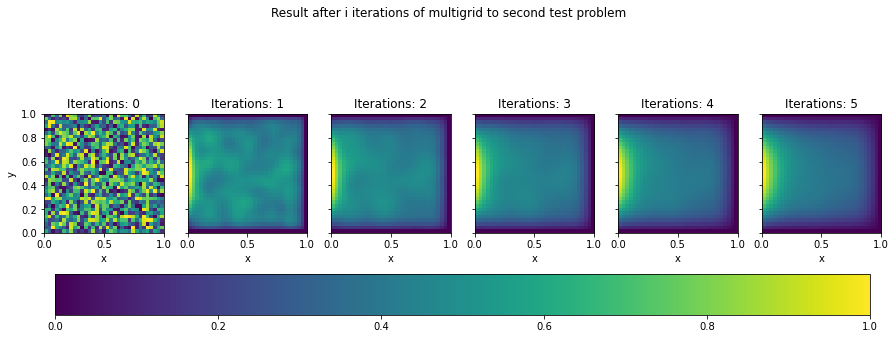

In [23]:
title = "Result after i iterations of multigrid to second test problem"
iterations = 5
N = 2 ** iterations
rhs = CaseTwo.get_rhs(N)
U_0 = CaseTwo.get_u_0(N)
fig = plot_first_iterations(iterations=iterations, method=mgv_minus_poisson, U_0=U_0, title=title, rhs=rhs, N=N, nu1=5,
                            nu2=2, max_level=2)

Plot convergence history of $N=2^5$ for the multigrid solver with 100 pre-smoothings and post-smoothings:

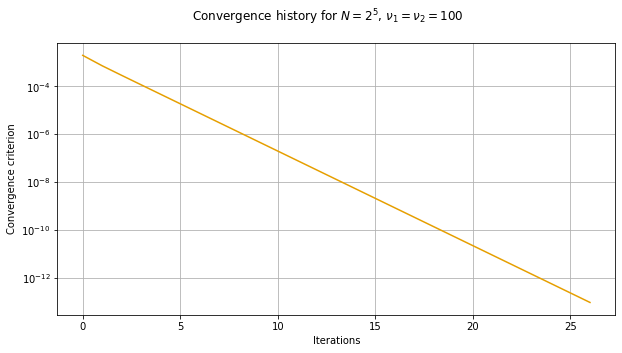

In [9]:
fig = plot_convergence(method=multigrid_minus_poisson, title="Convergence history for $N=2^5$, $\\nu_1=\\nu_2=100$",
                       x_0=U_0, rhs=rhs, N=N,
                       nu1=100, nu2=100, max_level=2)

Plot convergence history of $N=2^5$ for the multigrid solver with 5 post-smoothings and 2 post-smoothings:

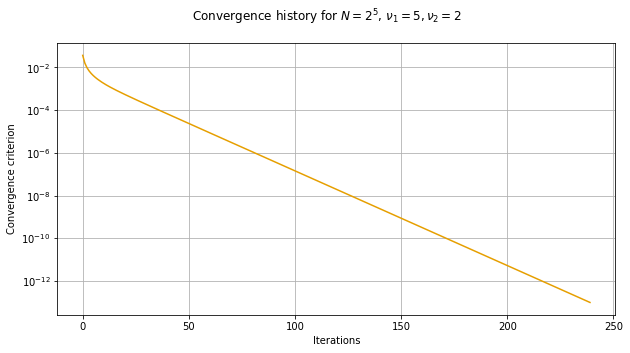

In [22]:
fig = plot_convergence(method=multigrid_minus_poisson, title="Convergence history for $N=2^5$, $\\nu_1=5,\\nu_2=2$",
                       x_0=U_0, rhs=rhs, N=N,
                       nu1=5, nu2=2, max_level=2)

We now try the iterative multigrid solver on test problem 2 with grid size $N=2^L, L \in [5,6,7,8,9,10]$.
The number of iterations to convergence for each $L$ is shown below.

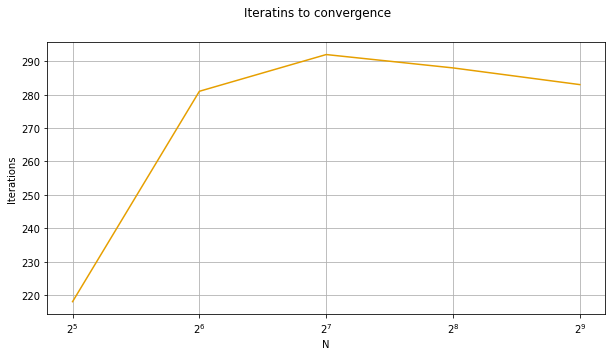

In [11]:
L_list = [5, 6, 7, 8, 9]
N_list = 2 ** np.array(L_list, dtype=np.int64)
fig = plot_convergence_iters_to_convergence(method=multigrid_minus_poisson, case=CaseTwo, N_list=N_list, nu1=5, nu2=2,
                                            max_level=2)

We see that the number of iterations to convergence (almost) **does not increase with the size of the problem**.
The number of V-cycles to convergence looks independent of the problem size; and for this problem it takes about 200-300 V-cycles to converge.
This does not take into account the number of iterations for the conjugate gradient solver running in our multigrid implementation.
For larger $N$ the conjugate gradient will have to solve a larger system which for this problem requires more iterations.
It also takes significantly more time to solve the system when increasing $N$.

## Exercise 3
We implement conjugate gradient with multigrid as a preconditioner.
To precondition conjugate gradient with a matrix $M$, the matrix must be **symmetric positive definite**.
The reason $M$ must be SPD is that preconditioned conjugate gradient relies on $M$ defining an inner product as such:

\begin{equation}
(x,y)_M = (Mx,y).
\end{equation}

We know that $M$ can only define an inner product this way if it is SPD. Thus, the result follows.

When using a multigrid V-cycle as a preconditioner we treat one V-cycle as a linear operator corresponding to $M^{-1}$.
Thus, we must require that one application of a V-cycle is symmetric positive definite.
We do not show that this is the case for our problem as it was not required.

Multigrid preconditioned conjugate gradient is implemented in the cell below:

In [12]:
from linalg.preconditioned import *

We show the result of the first 5 applications of the preconditioned solver:

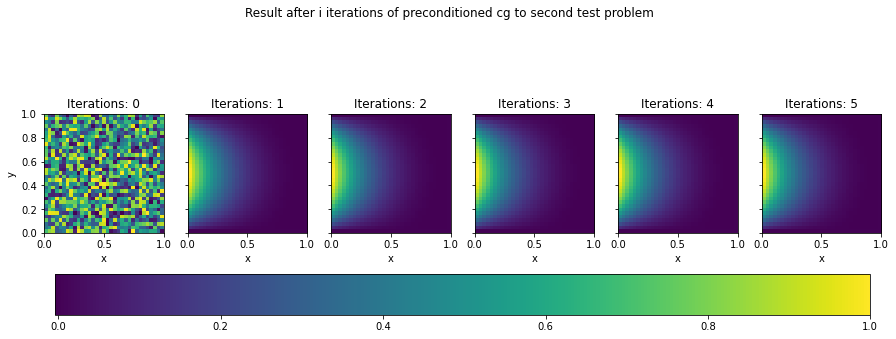

In [18]:
title = "Result after i iterations of preconditioned cg to second test problem"
iterations = 5
N = 2 ** iterations
rhs = CaseTwo.get_rhs(N)
U_0 = CaseTwo.get_u_0(N)
fig = plot_first_iterations(iterations=iterations, method=mgv_conditioned_cg_minus_poisson, U_0=U_0, title=title,
                            rhs=rhs, N=N, nu1=5,
                            nu2=2, max_level=2)

Plot convergence history of $N=2^5$ for the preconditioned conjugate gradient algorithm:

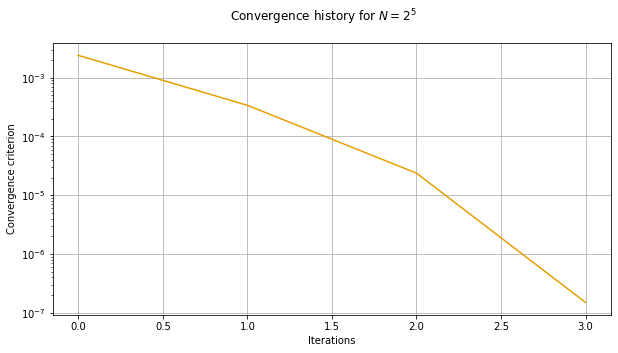

In [19]:
fig = plot_convergence(method=mgv_conditioned_cg_minus_poisson, title="Convergence history for $N=2^5$",
                       x_0=U_0, rhs=rhs, N=N,
                       nu1=100, nu2=100, max_level=2)

Finally, we find the number of iterations to convergence for  different problem sizes $N=2^L, L \in [5,6,7,8,9,10]$

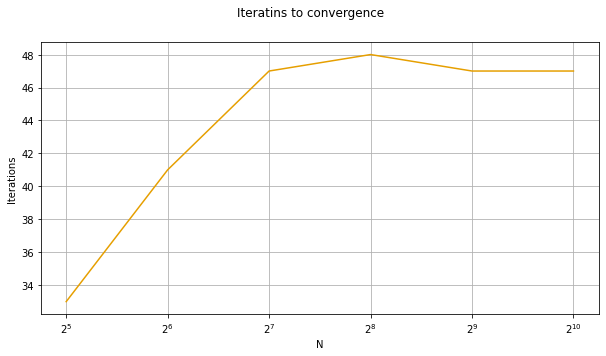

In [29]:
L_list = [5, 6, 7, 8, 9, 10]
N_list = 2 ** np.array(L_list, dtype=np.int64)
fig = plot_convergence_iters_to_convergence(method=mgv_conditioned_cg_minus_poisson, case=CaseTwo, N_list=N_list, nu1=5,
                                            nu2=2, max_level=2)

From the numerical experiments above we observe that the number of iterations to reach convergence is similar to multigrid.
The number of iterations needed to reach convergence seems constant after a sufficiently large problem is reached.
The number of iterations needed to converge is the about 50

